# Lab 2

In [529]:
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
from random import randrange as rand

im_lena = np.array(Image.open("Images_TP/Lena.jpg"))
im_grey_lena = np.array(Image.open("Images_TP/Lena.jpg").convert('L'))
im_noise = np.array(Image.open("Images_TP/noise.tif"))
im_clown = np.array(Image.open("Images_TP/clown.tif"))
im_noisy_lena = np.array(Image.open("Images_TP/noisy_Lena.png"))[:,:,(0,1,2)] #RGBa to RGB
im_mercury = np.array(Image.open("Images_TP/mercury.tif"))
im_texte_a_restaurer = np.array(Image.open("Images_TP/texte_a_restaurer.png"))[:,:,(0,1,2)] #RGBa to RGB
im_photo_a_restaurer = np.array(Image.open("Images_TP/photo_a_restaurer.png"))

img_mark = Image.open("Images_TP/Mark.png")
img_flagFR = Image.open("Images_TP/France.png")
img_flagDE = Image.open("Images_TP/Allemagne.png")
img_flagCH = Image.open("Images_TP/Suisse.png")
img_flagHR = Image.open("Images_TP/Croatie.png")

# Image.fromarray(im_dungeon).show()
def show2(im_ref,im,cmap= 'viridis',cmap_ref='viridis',title1='Before',title2='After',size=9):
    if size < 11 :
        f, axarr = plt.subplots(1,2)    #subplot(r,c) -> r:nb_rows, c:nb_columns
    else:
        f, axarr = plt.subplots(2,1)    #subplot(r,c) -> r:nb_rows, c:nb_columns
    axarr[0].set_title(title1)
    axarr[0].imshow(im_ref,cmap=cmap_ref)
    axarr[1].set_title(title2)
    axarr[1].imshow(im,cmap=cmap)
    f.set_figheight(size)
    f.set_figwidth(size)

def show3(im_ref,im1, im2,cmap= 'viridis',cmap_ref='viridis',title1='Step 1',title2='Step 2',size=10):
    if size < 11 :
        f, axarr = plt.subplots(1,3)    #subplot(r,c) -> r:nb_rows, c:nb_columns
    else:
        f, axarr = plt.subplots(3,1)    #subplot(r,c) -> r:nb_rows, c:nb_columns
    axarr[0].set_title('Original')
    axarr[0].imshow(im_ref,cmap=cmap_ref)
    axarr[1].set_title(title1)
    axarr[1].imshow(im1,cmap=cmap)
    axarr[2].set_title(title2)
    axarr[2].imshow(im2,cmap=cmap)
    f.set_figheight(size)
    f.set_figwidth(size)

def show_histo(hist,title='Histogramme'):
    plt.figure(figsize=(8, 2))
    plt.title(title)
    plt.bar(range(len(hist)), hist, color='gray')

def show1_grey(im,hist=True,title='Original',size=10):
    #affiche l'image de gris, l'histo et l'histocumulé si True
    if hist:
        if size < 11 :
            f, axarr = plt.subplots(1,3,figsize=(size, size//4))    #subplot(r,c) -> rows, columns
        else:
            f, axarr = plt.subplots(3,1,figsize=(size, size//4))    #subplot(r,c) -> rows, columns
        axarr[0].set_title(title)
        axarr[0].imshow(im,cmap='grey')
        histo = build_histo(im)
        axarr[1].set_title("Histogramme")
        axarr[1].bar(range(len(histo)), histo)
        histocumul = build_histo_cumul(histo)
        axarr[2].set_title('Histogramme cumulé')
        axarr[2].bar(range(len(histocumul)), histocumul)
    else :
        plt.figure(figsize =(size,size))
        plt.imshow(im,cmap='grey')
        plt.title(title)


def grey(im):
    R, G, B = im[:, :, 0], im[:, :, 1], im[:, :, 2]
    return (0.2989 * R + 0.5870 * G + 0.1140 * B).astype(np.uint8)

def linear_filter_RGB(im,filtre):
    height, width, nb_channels = im.shape
    size_filtre = filtre.shape[0]
    assert(nb_channels < 4)        #besoin image RGB
    assert(size_filtre%2 == 1) #filtre carré de taille impaire
    bord = size_filtre//2
    img = np.zeros_like(im)
    for y in range(bord,height-bord):
        for x in range(bord,width-bord):
            for c in range(0,nb_channels):
                temp = np.sum(im[y-bord:y+bord+1,x-bord:x+bord+1,c]*filtre)    #temp : float64
                img[y,x,c] = temp*(temp>=0) if (temp<255) else 255    #saturation
    return img

def sharpen(im):
    filtre = np.array([[0,-0.5,0],
                       [-0.5,3,-0.5],
                       [0,-0.5,0]])
    return linear_filter_RGB(im,filtre)

def build_histo(im,dtype=int):
    assert(len(im.shape)==2)    #ne supporte qu'une couleur
    assert(im.dtype == np.uint8)    #ne supporte que des valeurs entre 0 et 255
    nb_classes = 256
    histo = np.zeros([nb_classes],dtype=dtype) #histo = [0]*nb_classes
    for i in im.ravel():
        histo[int(i)] += 1
    return histo

def build_histo_cumul(histo):
    histo_cumul = np.empty_like(histo)
    temp = 0
    for i,h in enumerate(histo):
        temp += h 
        histo_cumul[i] = temp
    return histo_cumul

def normalize(im):
    img = im.copy()
    img_max = np.max(img)
    img_min = np.min(img)
    img = 255 * ((img-img_min)/(img_max-img_min))
    return img.astype(np.uint8)
#Rq : auto-contrast/normalise : I'(x,y)=255*(I(x,y)-Imin)/(Imax-Imin)

def equalize(im) :
    img = np.empty_like(im)
    #construit l'histogramme
    proba_k = build_histo(im,dtype=float)
    nb_classes = len(proba_k) # = 256
    #normalise l'histogramme
    size_image = im.shape[0]*im.shape[1]  # =539460
    for k in range(0,nb_classes):
        proba_k[k] /= size_image   #col_liste = probabilité par classes
    #transforme (uniformise la répartition des niveaux de gris)
    for y in range(0,len(img)):
        for x in range(0,len(img[0])):
            img[y,x] = (nb_classes-1) * np.sum([proba_k[k] for k in range(0,int(im[y,x])+1) ])
    return img


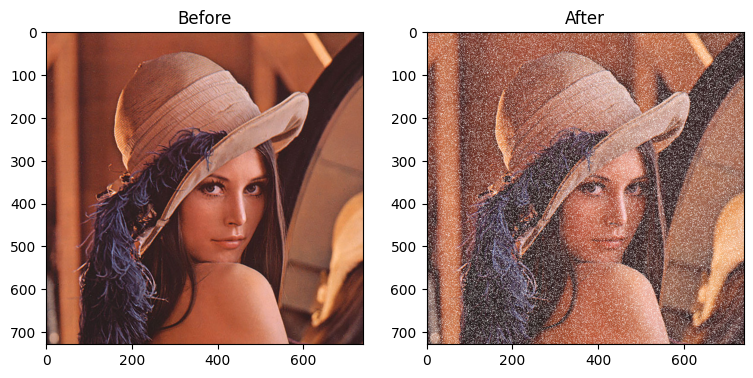

In [130]:
def add_noise(im,size=1,ratio=1/6):
    #ratio : nb de pixels bruités par pixels de l'image
    img = im.copy()
    nb_channels = 3 if len(im.shape)==3 *3 else 2
    nb_alea = int((im.shape[0] * im.shape[1])*(ratio/size**2))
    if nb_channels == 3:
        noise = [[[255]*nb_channels]*size]*size
    else :
        noise = [[255]*size]*size
    for _ in range(0,nb_alea):
        x = rand(0,im.shape[0])
        y = rand(0,im.shape[1])
        if img[x:x+size,y:y+size].shape == (size,size,3):
            img[x:x+size,y:y+size] = noise
    return img

im_noisy_lena2 = add_noise(im_lena,1)
show2(im_lena,im_noisy_lena2)

## 1.  Le filtre médian, un filtre non-linéaire

La technique de filtre médian est largement utilisée en 
traitement d'images numériques, car elle permet de réduire le bruit tout en conservant les contours de 
l'image. L'idée principale du filtre médian est de remplacer chaque pixel par la valeur médiane de son 
voisinage.\
Le filtre médian va d'abord trier ces valeurs par ordre croissant, et prendre la valeur médiane.

In [2]:
def median_filter_RGB(im,size_filtre):
    #size_filtre : nb de pixels sur un côté
    height, width, nb_channels = im.shape
    assert(nb_channels < 4)        #besoin image RGB
    assert(size_filtre%2 == 1)      #filtre de taille impaire
    bord = size_filtre//2
    img = np.zeros_like(im)
    for y in range(bord,height-bord):
        for x in range(bord,width-bord):
            for c in range(0,nb_channels):
                input = im[y-bord:y+bord+1,x-bord:x+bord+1,c]
                img[y,x,c] = np.median(input,axis=None)
    return img

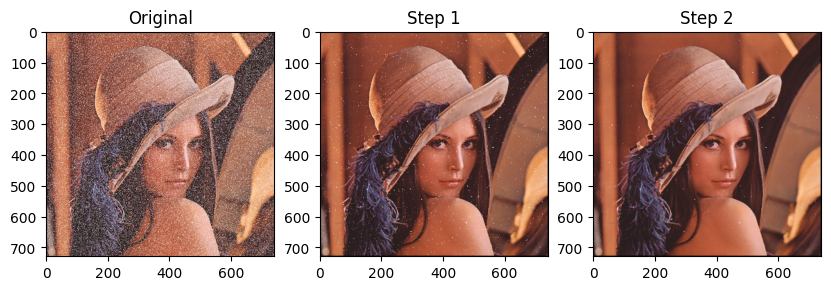

In [4]:

im_temp = median_filter_RGB(im_noisy_lena2,3)
im_temp2 = median_filter_RGB(im_temp,3)
show3(im_noisy_lena2,im_temp,im_temp2)

Plusieurs passages du filtre permet d'enlever (presque) tout le bruit.\
Un grain de bruit plus gros nécessite un filtre médian plus large, mais réduit la qualité de l'image (lissage)

## 2. Filtrage bruit périodique

In [3]:
def specral_imageGray(im):
    #applique la transformée de fourier (FFT) sur l'image im
    img = np.fft.fft2(im)
    return np.fft.fftshift(img) #centre la fondamentale

def view_spectral(im):
    #prépare l'image spectrale pour la visualiser
    return np.log(abs(im))

def imageGrey_from_spectral(im):
    #reconstruit l'image à partir de l'image de base
    reconstructed = abs(np.fft.ifft2(im))
    return normalize(reconstructed).astype(np.uint8)    #certaines valeurs dépassent 255

def symetrical_star_mask(im,masks):
    #construit un masque composé d'étoiles avec une symétrie centrale
    # masks : liste d'étoiles (centre,size,width)
    mask = np.zeros_like(im,dtype=np.uint8)
    y_center = im.shape[0]//2
    x_center = im.shape[1]//2
    for (y,x,size,width) in masks :
        if size != width :
            mask[y-size:y+size,x-width:x+width] = 1
            mask[-y-size:-y+size,-x-width:-x+width] = 1
            mask[y-width:y+width,x-size:x+size] = 1
            mask[-y-width:-y+width,-x-size:-x+size] = 1
        else:
            mask[y-size:y+size,x-size:x+size] = 1
            mask[-y-size:-y+size,-x-size:-x+size] = 1
    return 1-mask

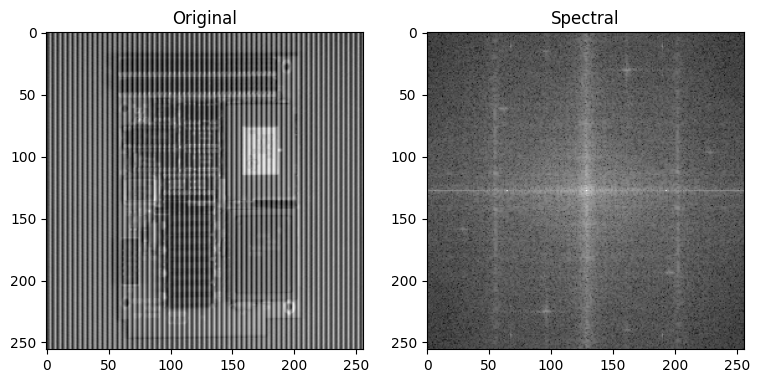

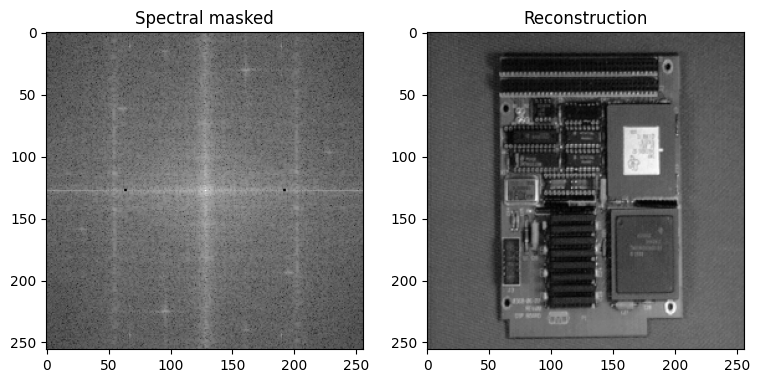

In [132]:
im_temp = specral_imageGray(im_noise)
show2(im_noise,view_spectral(im_temp),cmap='grey',cmap_ref='grey',
      title1='Original',title2='Spectral')

y = im_noise.shape[0]//2
mask = symetrical_star_mask(im_temp,[(y,64,1,1)])
im_temp2 = im_temp * mask    #applique le masque
im_temp2 = imageGrey_from_spectral(im_temp2)

show2(view_spectral(im_temp)*mask,im_temp2,cmap='grey',cmap_ref='grey',
      title1='Spectral masked',title2='Reconstruction')

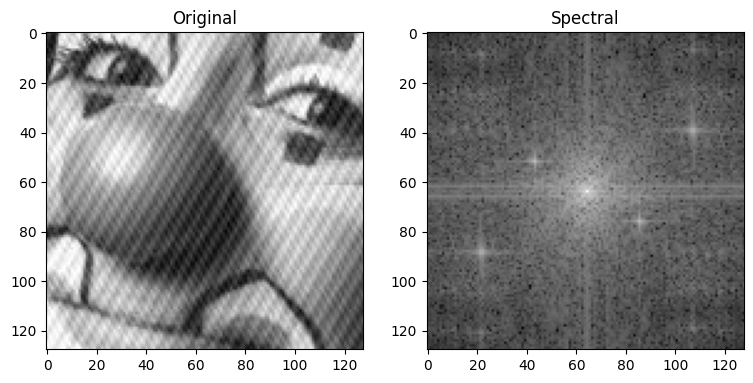

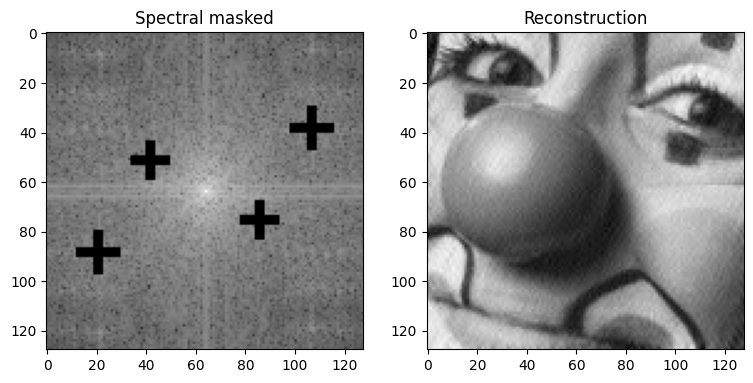

In [133]:
im_temp = specral_imageGray(im_clown)
show2(im_clown,view_spectral(im_temp),cmap='grey',cmap_ref='grey',
      title1='Original',title2='Spectral')

mask = symetrical_star_mask(im_temp,[(89,21,9,2),(52,42,8,2)])
im_temp2 = im_temp * mask    #applique le masque
im_temp2 = imageGrey_from_spectral(im_temp2)

show2(view_spectral(im_temp)*mask,im_temp2,cmap='grey',cmap_ref='grey',
      title1='Spectral masked',title2='Reconstruction')

## 3. Noise reduction

In [170]:
im_temp = median_filter_RGB(im_mercury,3)
im_temp2 = sharpen(im_temp)

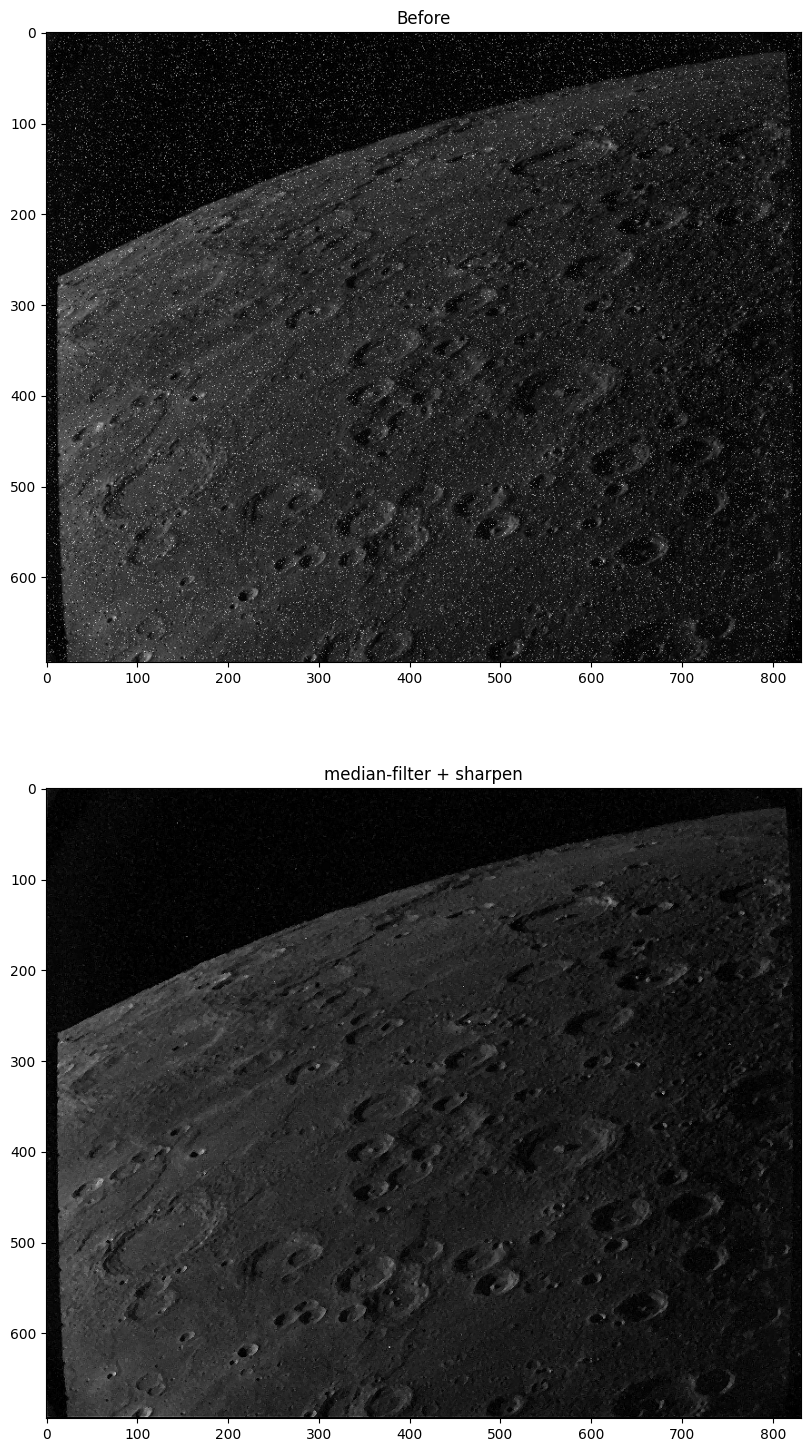

In [ ]:
show2(im_mercury,im_temp2,size=18,title2="median-filter(3px) + sharpen")

Le median-filter avec une taille de 3 pixels est ici suffisant, on fait un sharpen pour améliorer l'image

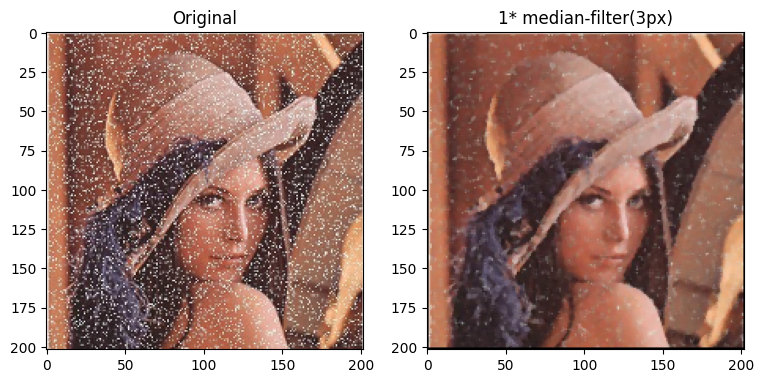

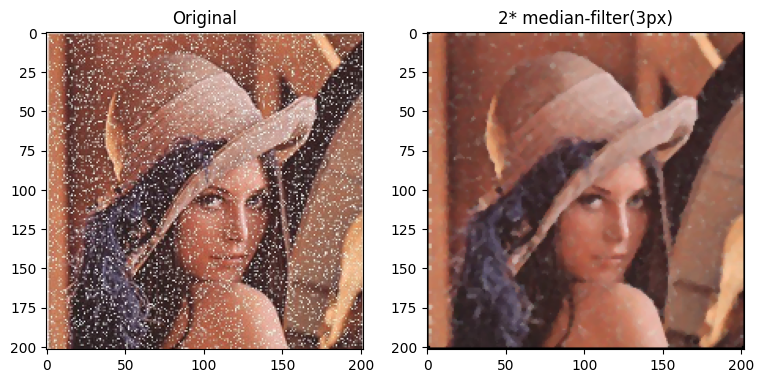

In [235]:
im_temp = median_filter_RGB(im_noisy_lena,3)
im_temp2 = median_filter_RGB(im_temp,3)
show2(im_noisy_lena,im_temp,title1="Original",title2="1* median-filter(3px)")
show2(im_noisy_lena,im_temp2,title1="Original",title2="2* median-filter(3px)")

On choisit un median-filter de 3px*3px et on le passe 2 fois.\
Résultat : Trop de pertes ici avec le median-filter car la résolution de l'image est trop faible\
De plus la taille de 3 * 3 (taille minimale) ne fait que réduire le bruit, il faudrait une taille de 5 * 5 pour tout enlever mais on pert trop en qualité d'image. \
La résolution de l'image étant faible et le grain de bruit gros, le median-filter est ici insuffisant.\
Peut-être avec des wavelets ?

## 4.  Fusion photo 

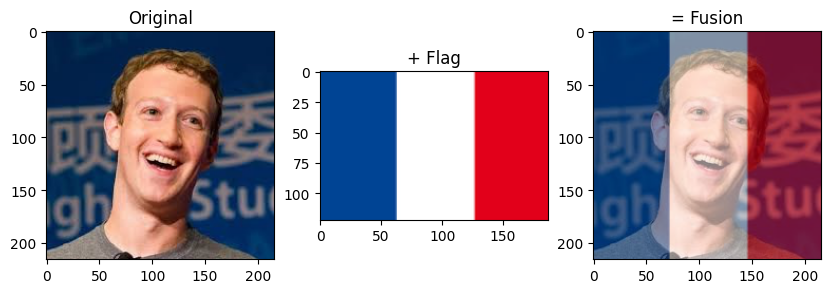

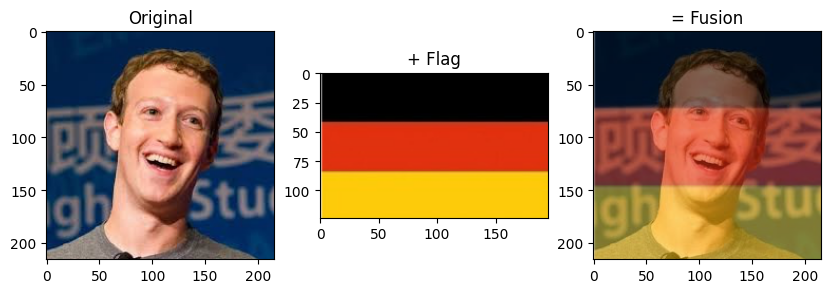

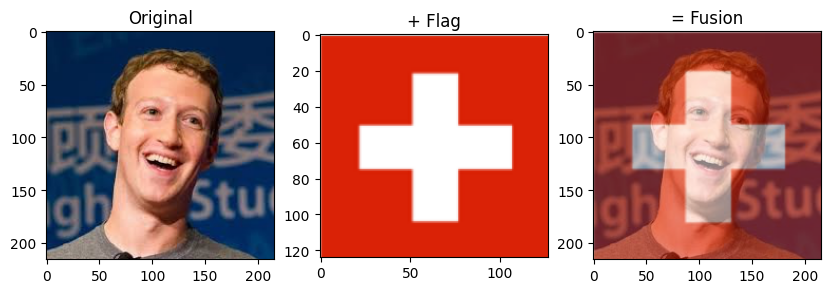

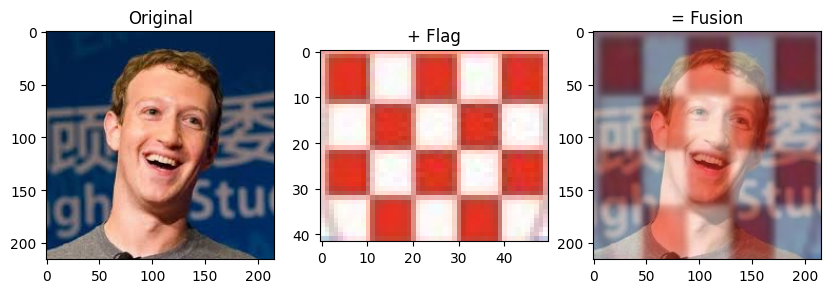

In [40]:
def fusion(img_base,img):
    im_base = np.array(img_base)
    im_temp = np.array(img.resize(img_base.size))  #img.size : (width,height)
    return (im_base *.5 + im_temp*.5).astype(np.uint8)

img_flag = img_flagFR
im_temp = fusion(img_mark,img_flag)
show3(img_mark,img_flag,im_temp,title1="+ Flag",title2="= Fusion")

img_flag = img_flagDE
im_temp = fusion(img_mark,img_flag)
show3(img_mark,img_flag,im_temp,title1="+ Flag",title2="= Fusion")

img_flag = img_flagCH
im_temp = fusion(img_mark,img_flag)
show3(img_mark,img_flag,im_temp,title1="+ Flag",title2="= Fusion")

img_flag = img_flagHR.crop((71,41,121,83))    # img.crop((left, upper, right, lower))
im_temp = fusion(img_mark,img_flag)
show3(img_mark,img_flag,im_temp,title1="+ Flag",title2="= Fusion")




## 5.  Égalisation  exacte  d’histogramme

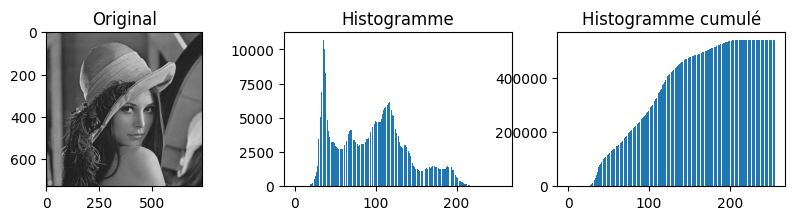

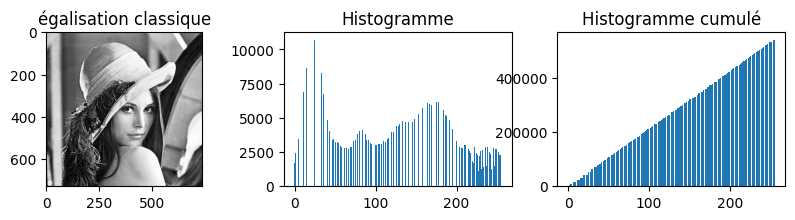

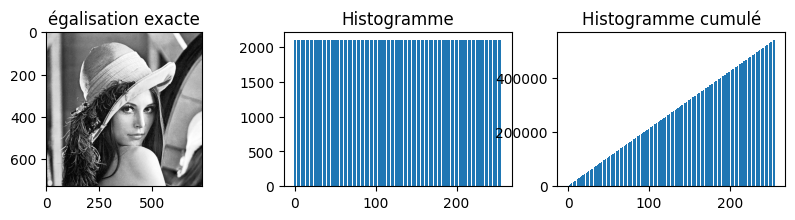

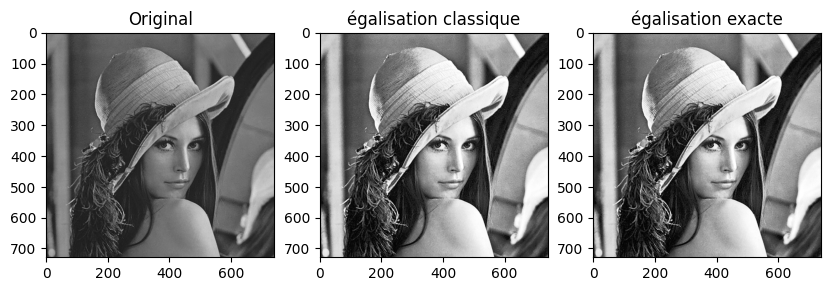

In [232]:
def homogenize(im) :
    #homogénéise l'histo d'une image grise (pré-égalisée)
    #Rq : optimisation -> faire les 3 en 1 (normalise,equalise,homogenize)
    img = np.empty_like(im)
    #construit l'histogramme
    col = build_histo(im)
    #homogénéise
    n = np.mean(col)    #n: le nombre de pixels par niveaux de gris voulut
    [sorted_y,sorted_x] = np.unravel_index(np.argsort(im, axis=None), im.shape)
    i=0
    for (y,x) in zip(sorted_y,sorted_x):
        img[y,x] = i//n
        i+=1
    return img

def equalize3(im):
    return homogenize(equalize(normalize(im)))


im_grey_lena = normalize(im_grey_lena)

#image originale (grise normalisée)
show1_grey(im_grey_lena)

#égalisation classique (à partir de l'image normalisée)
im_temp = equalize(im_grey_lena)
show1_grey(im_temp,title='égalisation classique')

#égalisation exacte (à partir de l'image égalisée)
im_temp2 = homogenize(im_temp)  #== equalize3(im_grey_lena)
show1_grey(im_temp2,title='égalisation exacte')

#Comparaison des 3 résultats
show3(im_grey_lena,im_temp,im_temp2,
      title1='égalisation classique',title2='égalisation exacte',cmap='grey',cmap_ref='grey')

## 6.  Restauration  de  documents  imprimés

In [525]:
def threshold(im,seuil):
    img = np.copy(im)
    img[img < seuil ] = 0
    img[img > seuil] = 255
    return img

def linear_filter_grey(im,filtre):
    height, width = im.shape
    size_filtre = filtre.shape[0]
    assert(size_filtre%2 == 1) #filtre carré de taille impaire
    bord = size_filtre//2
    img = np.zeros_like(im)
    for y in range(bord,height-bord):
        for x in range(bord,width-bord):
            temp = np.sum(im[y-bord:y+bord+1,x-bord:x+bord+1]*filtre)    #temp : float64
            img[y,x] = temp*(temp>=0) if (temp<255) else 255    #saturation
    return img

def lisse_grey(im,size_filtre):
    assert(size_filtre%2 == 1)      #filtre de taille impaire
    filtre = np.array([[1/(size_filtre**2)]*size_filtre]*size_filtre)
    return linear_filter_grey(im,filtre)

def median_filter_grey(im,size_filtre):
    #size_filtre : nb de pixels sur un côté
    assert(len(im.shape) == 2)        #besoin image grey
    height, width = im.shape
    assert(size_filtre%2 == 1)      #filtre de taille impaire
    bord = size_filtre//2
    img = np.zeros_like(im)
    for y in range(bord,height-bord):
        for x in range(bord,width-bord):
                input = im[y-bord:y+bord+1,x-bord:x+bord+1]
                img[y,x] = np.median(input,axis=None)
    return img

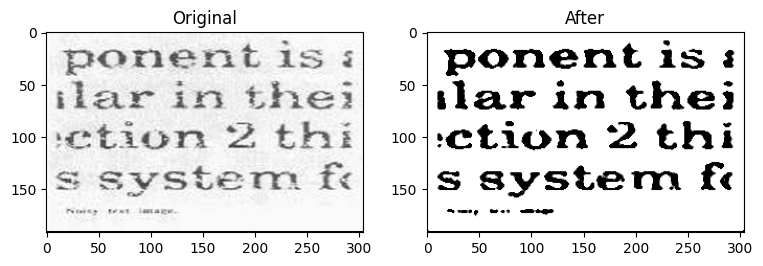

In [533]:
#On réccupère le texte
im_temp = normalize(grey(im_texte_a_restaurer))

#méthode 1:
im_temp3 = threshold(im_temp,215)
im_temp2 = median_filter_grey(im_temp3,3)

#méthode 2:
im_temp3 = lisse_grey(im_temp3,3)
im_temp3 = threshold(im_temp3,170)  
im_temp3 = lisse_grey(im_temp3,3)
im_temp3 = threshold(im_temp3,95)  
im_temp3 = median_filter_grey(im_temp3,3)

#moyenne
im_temp3 = (im_temp2*.5 + im_temp3 * .5).astype(np.uint8)
show2(im_temp,im_temp3,cmap='grey',cmap_ref='grey',title1='Original')



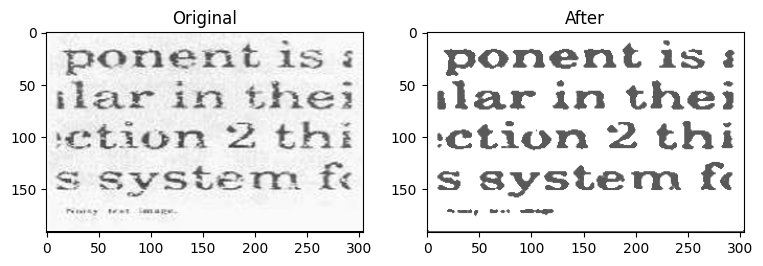

In [534]:
#On met la couleur souhaitée au texte : 90
im_temp4 = 255 - im_temp3
im_temp4 = im_temp3 + (im_temp4//255)*90
im_temp4[0,0]=0  ; im_temp4[-1,-1]=255  #besoin pour l'affichage imshow
im_temp4 = im_temp4.astype(np.uint8)
show2(im_temp,im_temp4,cmap='grey',cmap_ref='grey',title1='Original')

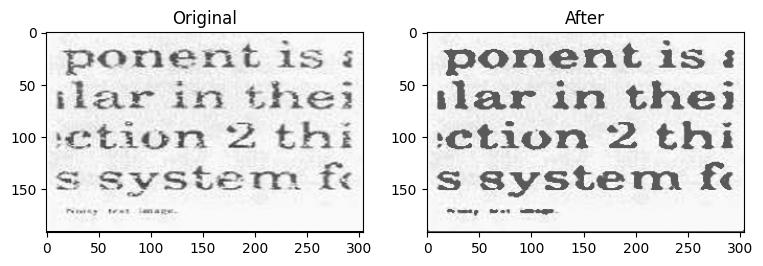

In [535]:

#On prend le fond
im_temp2 = im_temp * (im_temp3//255)
#On ajoute le texte coloré sur le fond
im_temp2 = im_temp2 + im_temp4
show2(im_temp,im_temp2,cmap='grey',cmap_ref='grey',title1='Original')


## 7.  Restauration de photo

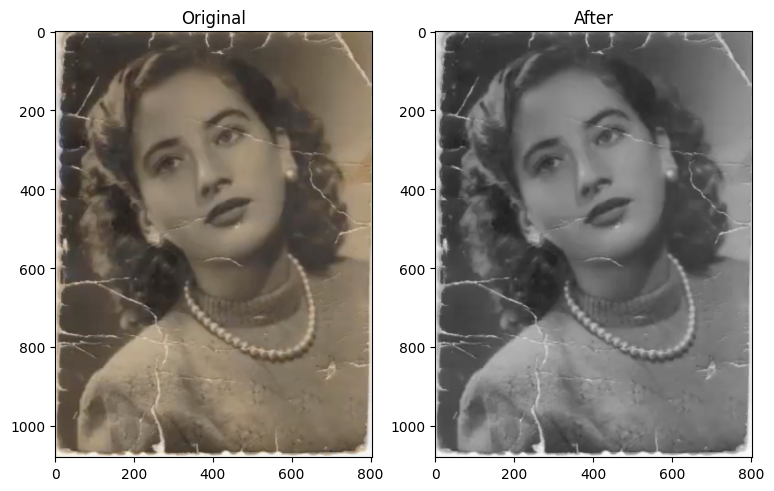

In [543]:
im_temp = normalize(grey(im_photo_a_restaurer))

show2(im_photo_a_restaurer,im_temp,cmap='grey',cmap_ref='grey',title1='Original')

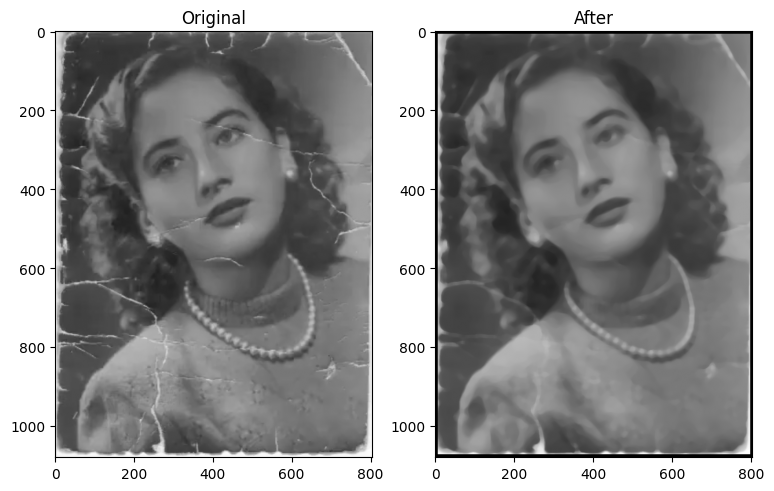

In [550]:
im_temp2 = median_filter_grey(im_temp,15)
show2(im_temp,im_temp2,cmap='grey',cmap_ref='grey',title1='Original')

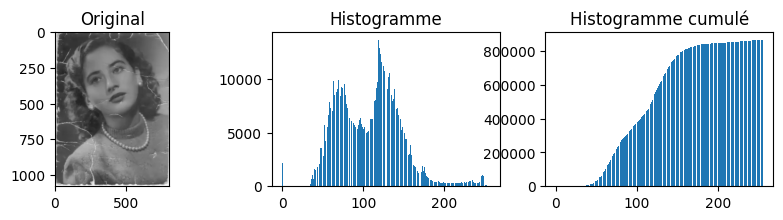

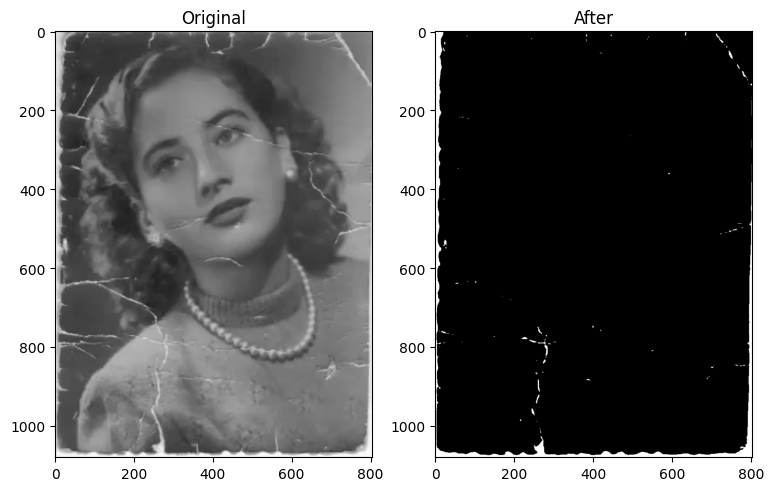

In [562]:
show1_grey(im_temp)
im_temp3 = threshold(im_temp,190)
show2(im_temp,im_temp3,cmap='grey',cmap_ref='grey',title1='Original')

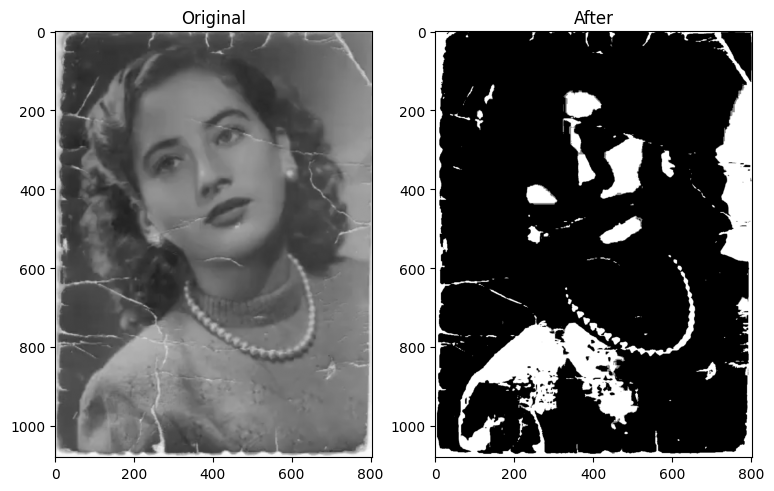

In [570]:

im_temp3 = threshold(im_temp,140)
show2(im_temp,im_temp3,cmap='grey',cmap_ref='grey',title1='Original')